> Reference:
>
> Unveiling the Power of Projected Gradient Descent in Adversarial Attacks: https://medium.com/@zachariaharungeorge/unveiling-the-power-of-projected-gradient-descent-in-adversarial-attacks-2f92509dde3c
>
> Working with Results: https://docs.ultralytics.com/modes/predict/#working-with-results
>
> Understanding output of .pt file of YOLOv8: https://github.com/ultralytics/ultralytics/issues/8421

# Issues (fixed)
In the `pgd_attack(model, images, labels, epsilon, alpha, num_iterations)` funtion, the outputs of `model(perturbed_images)` is a list. It's make sense since in the Ultralytics documentation`All Ultralytics predict() calls will return a list of Results objects`. However, the `CrossEntropyLoss()` here requires `argument 'input' (position 1) must be Tensor, not list`. I then check the above Github issues, seems like every pre-trained YOLOv8 model will return different result format. Not sure about YOLOv8 underlying way of handling output.

**Solution**: use the `classify_model` which includes the backbone, instead of using the YOLOv8 model directly.

# Working Mechanism of Projected Gradient Descent (PGD)

At the core of machine learning optimization lies the fundamental concept of gradient descent. This iterative algorithm fine-tunes model parameters to minimize a given loss function. Mathematically, the update rule is expressed as:

$$\Theta_{t+1} = \Theta_t - \alpha \cdot \nabla J(\Theta_t)$$

where $\Theta_t$ represents the parameters at iteration $t$, $\alpha$ is the learning rate, and $\nabla J(\Theta_t)$ is the gradient of the loss function.

## Projected Gradient Descent (PGD)

Projected Gradient Descent (PGD) builds upon this foundation, introducing thoughtful constraints to enhance its effectiveness in crafting adversarial examples. In the context of adversarial attacks, the objective is to perturb input data to deliberately mislead the model.

PGD incorporates a perturbation budget ($\epsilon$) and a step size ($\alpha$) to control the amount and direction of perturbation. The update rule for PGD is defined as:

$$x'_{t+1} = \Pi(x_t + \alpha \cdot \text{sign}(\nabla_x J(\Theta, x_t, y)))$$

where $x_t$​ is the input at iteration $t$, $\alpha$ is the step size, $\nabla_x J(\Theta, x_t, y)$ is the gradient of the loss with respect to the input, and $\Pi$​ is the projection operator ensuring perturbed input stays within predefined bounds.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.5/898.5 kB 21.5 MB/s eta 0:00:00


In [4]:
import torch
import torch.nn as nn
from ultralytics import YOLO
from torchvision import transforms
from PIL import Image
import numpy as np
import random

# Set the random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Step 1: Load trained YOLOv8 model
Model = YOLO('/content/drive/MyDrive/DM project/best.pt')
image_path = '/content/drive/MyDrive/DM project/stop.png'


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [72]:

# Step 2: Extract the backbone (CSPDarknet53)
backbone = Model.model.model[:10]
labels = torch.tensor([22])

num_classes = 29
sample_image = torch.randn(1, 3, 416, 416)  # Adjust size if necessary
sample_output = backbone(sample_image)
output_channels = sample_output.shape[1]

classify_model = nn.Sequential(
    backbone,  # Use the CSPDarknet53 backbone
    nn.AdaptiveAvgPool2d((1, 1)),  # Global Average Pooling to reduce to (batch_size, channels, 1, 1)
    nn.Flatten(),  # Flatten to (batch_size, channels)
    nn.Linear(in_features=output_channels, out_features=num_classes)  # Linear layer for classification
)
classify_model.eval()

preprocess = transforms.Compose([
    transforms.Resize((416, 416)),  # Resize to 416x416
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

image = Image.open(image_path).convert("RGB")  # Load image and ensure it's in RGB format
image = preprocess(image).unsqueeze(0)  # Apply preprocessing and add batch dimension

Implement Projected Gradient Descent (PGD) here.

In [73]:
import torch
import torch.nn as nn

def pgd_attack(model, images, labels, epsilon, alpha, num_iter):
    # Clone the input image and ensure it requires gradients
    perturbed_image = images.clone().detach().requires_grad_(True)
    perturbation = 0

    for i in range(num_iter):
        # Forward pass
        outputs = model(perturbed_image)
        model.zero_grad()
        loss = nn.CrossEntropyLoss()(outputs, labels)

        # Backward pass to compute gradients
        loss.backward()

        # Check if gradients are properly calculated
        if perturbed_image.grad is None:
            print("Gradient calculation failed.")
            break
        else:
            pass
            #print(f"Gradient norm: {perturbed_image.grad.norm().item()}")

        # Update perturbation using the gradient sign
        grad_sign = perturbed_image.grad.sign()
        perturbation += alpha * grad_sign
        #print(f"alpha is {alpha}")

        # Project perturbation to be within epsilon-ball
        perturbation = torch.clamp(perturbation, -epsilon, epsilon)

        # Update perturbed image with the projected perturbation

        perturbed_image = (perturbed_image + perturbation).detach().requires_grad_(True)
        if i%10==0:
          print(f"Iteration {i} complete.")

    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

# Example usage
epsilon = 0.05
alpha = 3e-5
num_iter = 100
normalised_image=torch.clamp(image, 0, 1)
perturbed_image_pgd = pgd_attack(classify_model, normalised_image, labels, epsilon, alpha, num_iter)


Iteration 0 complete.
Iteration 10 complete.
Iteration 20 complete.
Iteration 30 complete.
Iteration 40 complete.
Iteration 50 complete.
Iteration 60 complete.
Iteration 70 complete.
Iteration 80 complete.
Iteration 90 complete.


In [74]:
def get_yolo_output(model, image):
    results = model(image)
    return results[0].boxes.xyxy, results[0].boxes.conf, results[0].boxes.cls
boxes, scores, labels = get_yolo_output(Model, normalised_image)
perturbed_boxes, perturbed_scores, perturbed_labels = get_yolo_output(Model, perturbed_image_pgd)



0: 416x416 1 Stop_Sign, 287.8ms
Speed: 0.1ms preprocess, 287.8ms inference, 3.6ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 (no detections), 272.7ms
Speed: 0.0ms preprocess, 272.7ms inference, 3.2ms postprocess per image at shape (1, 3, 416, 416)


image 1 done


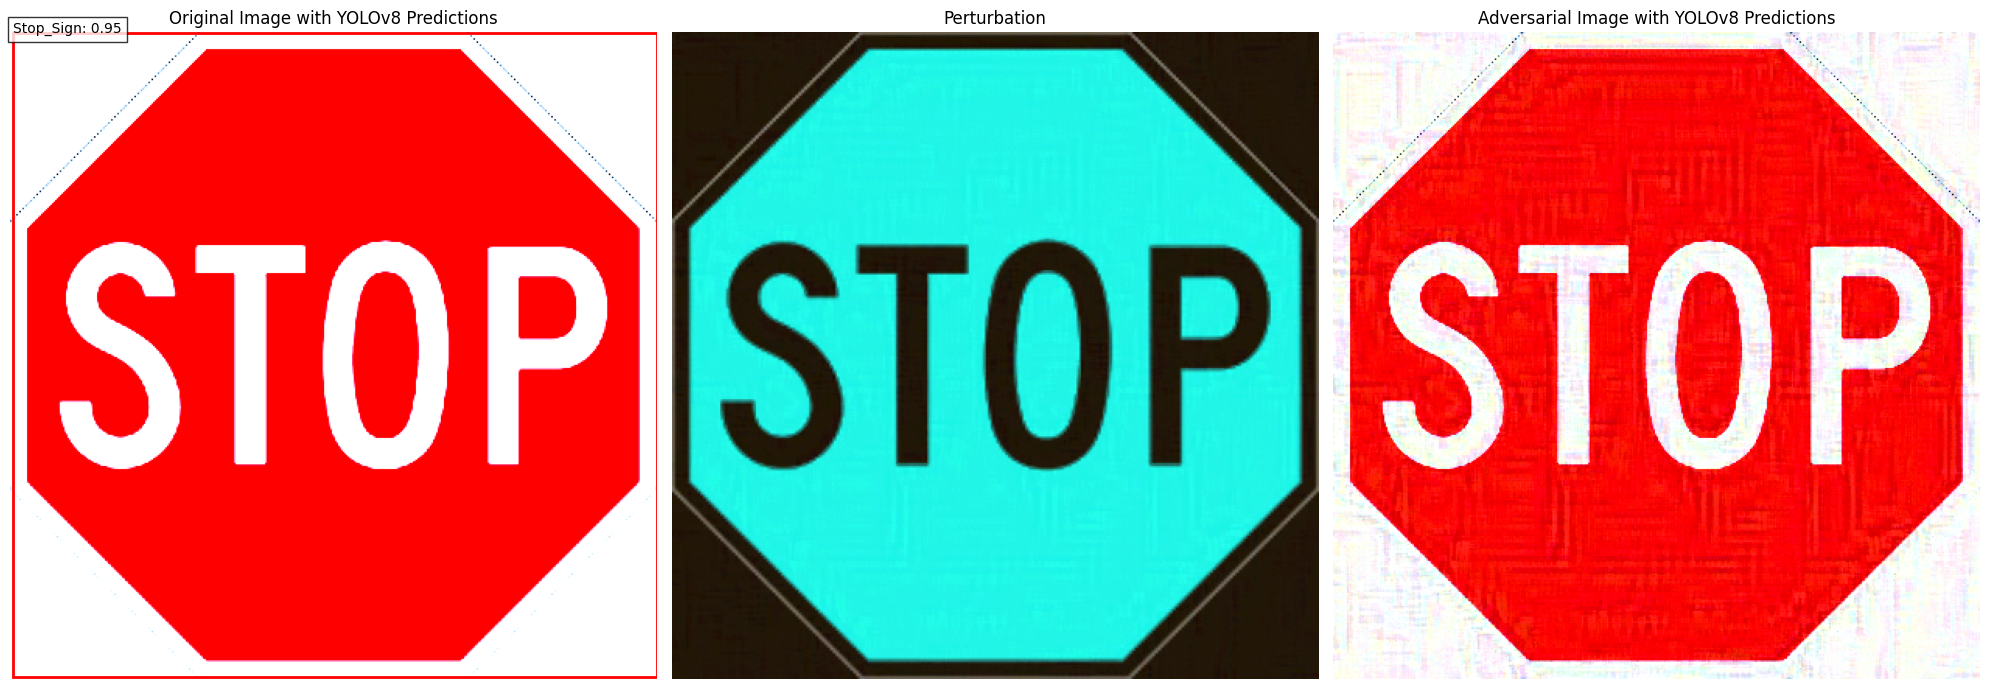

In [75]:
import matplotlib.pyplot as plt

def plot_boxes(ax, boxes, scores, labels, title, image_tensor):
    # Detach, remove batch dimension, permute to (height, width, channels), and convert to NumPy
    ax.imshow(image_tensor.squeeze(0).permute(1, 2, 0).cpu().detach().numpy())
    for box, score, label in zip(boxes, scores, labels):
        x1, y1, x2, y2 = box.detach().cpu().numpy()
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='r', linewidth=2)
        ax.add_patch(rect)
        ax.text(x1, y1, f"{Model.names[int(label)]}: {score:.2f}", bbox=dict(facecolor='white', alpha=0.8))
    ax.set_title(title)
    ax.axis('off')

fig, axs = plt.subplots(1, 3, figsize=(20, 10))


# Original image with predictions
plot_boxes(axs[0], boxes, scores, labels, "Original Image with YOLOv8 Predictions", normalised_image)
print("image 1 done")
# Perturbation
torch.save(perturbed_image_pgd - image, 'perturbation.pt')
perturbation = (perturbed_image_pgd - image).squeeze().permute(1, 2, 0).cpu().detach().numpy()
perturbation = (perturbation - perturbation.min()) / (perturbation.max() - perturbation.min())

axs[1].imshow(perturbation)
axs[1].set_title("Perturbation")
axs[1].axis('off')

# Adversarial image with predictions
plot_boxes(axs[2], perturbed_boxes, perturbed_scores, perturbed_labels, "Adversarial Image with YOLOv8 Predictions", perturbed_image_pgd)

plt.tight_layout()
plt.show()


In [34]:
Model.names

{0: '-Road narrows on right',
 1: '50 mph speed limit',
 2: 'Attention Please-',
 3: 'Beware of children',
 4: 'CYCLE ROUTE AHEAD WARNING',
 5: 'Dangerous Left Curve Ahead',
 6: 'Dangerous Rright Curve Ahead',
 7: 'End of all speed and passing limits',
 8: 'Give Way',
 9: 'Go Straight or Turn Right',
 10: 'Go straight or turn left',
 11: 'Keep-Left',
 12: 'Keep-Right',
 13: 'Left Zig Zag Traffic',
 14: 'No Entry',
 15: 'No_Over_Taking',
 16: 'Overtaking by trucks is prohibited',
 17: 'Pedestrian Crossing',
 18: 'Round-About',
 19: 'Slippery Road Ahead',
 20: 'Speed Limit 20 KMPh',
 21: 'Speed Limit 30 KMPh',
 22: 'Stop_Sign',
 23: 'Straight Ahead Only',
 24: 'Traffic_signal',
 25: 'Truck traffic is prohibited',
 26: 'Turn left ahead',
 27: 'Turn right ahead',
 28: 'Uneven Road'}